## Coronavirus Goes Randomly Viral

By Marianne Udtian, Marius Skårdal & Olufisayo Togun

### Abstract
The random walk describes a physical process in which individuals move accross a grid or space with random steps. The simulator runs over several iterations with certain parameters on a 50x50 grid, with an initial infected we get a scenario were the whole population is infected on average after 293 days. The case were ten people were initially infected, the population were infected on average after 150 days. The random walk process is compared with a classical analytical model. Using a numerically solved $\beta$, can be viewed as the disease transmission rate. $\beta$ is solved both numerically and analytically for the sake of comparison, where it was proven that the numerical $\beta$ was the better choice. Using the universal NumPy mean and median for beta, we obtained the best estimate for $\beta$ to be 0.65. Since the mean time of infection, $\tau_{sick}$, is related to $\beta$, we used the length of $\beta$ for  $\tau_{sick}$. The result seems to be in good fit with the random walk simulator, however, at day 100, the number of infected was more than 100 for the ODE solution.

### Introduction
The overall goal of this project is to implement a random walk simulator in a 2D lattice grid, $n_x \times n_y$. The position, x, of the walker after N steps is the sum of the individual steps:
$$
x(N) = \sum_{i=1}^N u_i
$$
For our 2D case, we have that the walkers can move either move one north, south, west or east which can be summarised as:
$$
u=\begin{equation}
\left\{ 
  \begin{aligned}
    (1, 0) && p = \frac{1}{4}\\
    (0, 1)  && p = \frac{1}{4}\\
    (-1, 0) && p = \frac{1}{4}\\
    (0, -1) && p = \frac{1}{4}
  \end{aligned}
  \right.
\end{equation}
$$
According to this, all walkers have the same probability $p = \frac{1}{4}=025$ to move either north, south, west, or east. In the very first part of the project, we only look at a two-compartment system, including only susceptible and infected. The first one, susceptible refers to people who could catch the disease, also known as healthy. The last one, infected, refers to people who have the disease and can spread it. In the simulator, we also include the risk of infection rate, which is given as a constant q=0.9. This is the chance of spreading the disease as a healthy person collides with an infected person. The simulator chooses a random number x between [0, 1]. If this number is smaller than q, a new walker is infected. A plot of susceptible vs infected is included for both the initial I(0)=1 and I(0)=10. 

One of the overall easiest ways to model the spread of an epidemic is by using the SI model, $S(t)+I(t)=N$. For each time step t, we divide the total population N into susceptible (S) and infected (I). In a more advanced model we include recovery time: $S(t)+I(t) + R(t)=N$
The random walk simulator is further compared with the ODE-based, deterministic SIR-model is:
$$
\frac{dS(t)}{dt} = -\beta(t) \cdot \frac{S(t)I(t)}{N} \\
\frac{dI(t)}{dt} = \beta(t) \cdot \frac{S(t)I(t)}{N} - \frac{I(t)}{\tau_{sick}} \\
\frac{dR(t)}{dt} = \frac{I(t)}{\tau_{sick}} 
$$
Her, $\beta$ is an effective contact (disease transmission) defined as: 
$$
\beta_n \cdot \Delta t \approx - \frac{(S(t_n)-S(t_n - \Delta t))N}{S(t_n)I(t_n)} = - \frac{(S_n-S_{n-1})N}{S(t_n)I(t_n)}
$$
Where $\beta_n$ is an estimate for $\beta$(t). Now, if we assume that $\beta$ is a constant, the analytical solution is:
$$
I(t)=\frac{N}{1+\frac{S_0}{I_0}exp(-\beta t)}
$$
Note that in the SIR model we included R, number of recovered patients. These are people who have had the desease, and have recovered and can therefore not get tha desease again. In other words, we will assume full imunity of people recovered.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import seaborn as sns
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.integrate
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.express as px

In [2]:
np.random.seed(22)
class RandomWalkEpidemicSimulator:
    def __init__(self,
                 no_init_infected,
                 loop=False,
                 ave_on=False,
                 t0=0,
                 plot_step=100,
                 tfinal=100,
                 population_size=683,
                 pop_size_old=123,
                 nx=50,
                 ny=50,
                 q=0.9,
                 r=0.01,
                 v=0.02,
                 p_v=0.9,
                 d=0.001,
                 SUSCEPTIBLE=0,
                 young=10,
                 old=11,
                 move_old=False,
                 store='off',
                 INFECTED=1,
                 plot=False,
                 DEAD=4,
                 potential=False,
                 VACCINATION=3,
                 potential_infection1=7,
                 potential_infection2=8,
                 recov_on=False,
                 vacc_on=False,
                 death_on=False,
                 RECOVERED = 2):
        self.potential=potential
        self.recov_on=recov_on
        self.vacc_on=vacc_on
        self.death_on=death_on
        self.N_ = population_size
        self.ave_on=ave_on
        self.old=old
        self.young=young
        self.pop_size_old=pop_size_old
        self.loop=loop
        self.I0_= no_init_infected
        self.plot_step=plot_step
        self.plot_=plot
        self.nx_= nx
        self.store=store
        self.ny_= ny
        self.t0=t0
        self.tfinal=tfinal
        self.infection_probability_ = q
        self.infection_probability_of_Vaccinated=p_v
        self.recovery_probability_=r
        self.death_probability=d
        self.vaccination_probability_=v
        self.Walkers_ = np.random.randint(0,[self.nx_, self.ny_],size=(self.N_, 2))
        self.SUSCEPTIBLE = SUSCEPTIBLE
        self.INFECTED = INFECTED
        self.VACCINATION=VACCINATION
        self.RECOVERED = RECOVERED
        self.POTENTIAL_INFECTED1=potential_infection1
        self.POTENTIAL_INFECTED2=potential_infection2
        self.DEAD = DEAD
        self.q=q
        self.move_old=move_old
        self.t_list = np.linspace(0, tfinal, 80)
        self.teninf=10      #used in the analytical solution for an intial infected of 10
        self.p_rec = 0.01
        self.State = np.full(self.N_, self.SUSCEPTIBLE)
        self.State[:self.I0_] = self.INFECTED
        self.RECOVERED = RECOVERED
        self.time=self.t0
        self.vacc_count=0
        self.State2=np.full(self.N_, self.young)
        self.State2[-self.pop_size_old:] = self.old # Allocation for old people

    def movement(self):

        '''This code controls the movement of people throughout the simulation, 
           the first part of the code account for slower movement with age.'''
        #next position
        #position for young and old people when this scenario is turned on
        if self.move_old==True:
            x_test_1=([[0,-1],[0,1],[1,0],[-1,0]])#positions for the young
            x=np.repeat(x_test_1,self.N_-self.pop_size_old,axis=0)
            randomizer1 = random.choices(list(x),k=self.N_-self.pop_size_old)
            randomizer1=np.array(randomizer1)

            x_test_2=([[0,-1],[0,1],[1,0],[-1,0],[0,0],[0,0],[0,0],[0,0]])#old people having a 50% chance of not moving at all
            x=np.repeat(x_test_2,self.pop_size_old,axis=0)
            randomizer2 = random.choices(list(x),k=self.pop_size_old)
            randomizer2=np.array(randomizer2)
            randomizer=np.concatenate((randomizer1, randomizer2))
        #position for general
        else:
            x_test=([[0,-1],[0,1],[1,0],[-1,0]])
            x=np.repeat(x_test,self.N_-self.pop_size_old,axis=0)
            randomizer = random.choices(list(x),k=self.N_)
            randomizer=np.array(randomizer)
        return(randomizer) 

        
    def pos(self):
        '''
        We define a position within the 2D lattice grid for all humans. Each person can move North, South, West, or East. 
        If the walker moves outside of the grid, the function will return the walker back to its original position.  
        If a susceptible is found in the same coordination as an infected, then theres a 0.9 probability that the susceptible changes state
        to an infected, The same concept applies for other states.

        The only part of the code that is not entirely distinct is the restricted movements of individuals outside the borders.
        we felt we will not need to alter the boundary of the system so there was no need to move this outside of this function
        
        The code runs in the following order, movement, vaccination, infection spreading, people dying, and people recovering.
        Note: people only start to get vaccinated after 90 days. (It states a  while for the vaccines to be developed)
        '''
        #next position
        moving=self.movement()

        #position and restriction
        self.Walkers_old = self.Walkers_.copy()
        self.Walkers_ += moving #self.next_pos()
        illegal_x = np.logical_or(self.Walkers_[:,0]<=0, self.Walkers_[:,0]>=self.nx_)
        illegal_y = np.logical_or(self.Walkers_[:,1]<=0, self.Walkers_[:,1]>=self.ny_)
        illegal_xy = np.logical_or(illegal_x, illegal_y)
        self.Walkers_[illegal_xy] = self.Walkers_old[illegal_xy]   

        #people get vaccinated
        if self.vacc_on==True and self.time>=90: #vaccination only occurs 150 days after infection spread has began
            self.vacc=self.vaccine()
            if self.time%100==0 and self.ave_on==False:
                print("Number of vaccinated at {} ={}".format(self.time,self.vacc))
        
        

        #infection spreading
        if self.loop==False:
            self.infection_spreading2()#no loop
        else:
            self.infection_spreading1()#one loop

        #people dying
        if self.death_on==True:
            self.death()
        
        #recovery
        if self.recov_on==True:
            self.recovery()
        
        self.time=self.time+1
        
        susceptible=self.Walkers_[self.State==self.SUSCEPTIBLE]
        infected=self.Walkers_[self.State==self.INFECTED]
        recovered=self.Walkers_[self.State==self.RECOVERED]
        vaccinated=self.Walkers_[self.State==self.VACCINATION]
        death= self.Walkers_[self.State==self.DEAD]
        
        return(susceptible,infected,recovered,vaccinated,death )
    
    


    def infection_spreading1(self):
        '''this code was the initial infection spreading code used, it contains a loop so it slows things down and is used for a test of runtime'''
        #infection spreading
        sick=self.Walkers_[self.State==self.INFECTED]
        all=self.Walkers_
        
        for i in range(0,len(sick)):
            if len(sick)>=self.N_:
                break
            else:
                xpos= np.where(all==sick[i], True, False).all(axis=1)
                pos_inf_prob=np.where(xpos==True)
                chance_become_sick=np.random.uniform(0,1)
                if chance_become_sick <= self.infection_probability_:
                    self.State[pos_inf_prob]=self.INFECTED #the guys become infected  
    
    def infection_spreading2(self):
        '''This function is what is used to spread the infection across the population and it contains no loops.
           The algorithm is constructed with a remapping transformation which only works as we have a perfect square 50x50.
           The idea was derived based on group discussions and with friends from other groups. '''

        #infection spreading for on susceptible people
        sick=self.Walkers_[self.State==self.INFECTED]
        All=self.Walkers_
        allready=All[:,0]+(All[:,1]*self.nx_)#remapping healthy
        sickready=sick[:,0]+(sick[:,1]*self.nx_)#remapping sick
        clash=np.isin(allready,sickready)
        clash=np.logical_and(clash,self.State==self.SUSCEPTIBLE)

        if clash.any():
            u=np.random.uniform(0,1, np.sum(clash))
            old_state=self.State[clash]

            if self.potential==True:
                self.State[self.State==self.POTENTIAL_INFECTED2]=self.INFECTED
                self.State[self.State==self.POTENTIAL_INFECTED1]=self.POTENTIAL_INFECTED2
                self.State[clash]=np.where(u<self.infection_probability_,self.POTENTIAL_INFECTED1,old_state)
            else:
                self.State[clash]=np.where(u<self.infection_probability_,self.INFECTED,old_state)
        #infection spreading for recovered  people
        if self.recov_on==True:
            clash_rec=np.logical_and(clash,self.State==self.RECOVERED)

            if clash_rec.any():
                u=np.random.uniform(0,1, np.sum(clash_rec))
                old_state=self.State[clash_rec]
                self.State[clash_rec]=np.where(u<self.infection_probability_of_Vaccinated,self.INFECTED,old_state)
        
        #infection spreading for vaccinated people

        if self.vacc_on==True:
            clash_vacc=np.logical_and(clash,self.State==self.VACCINATION)
            

            if clash_vacc.any():
                u=np.random.uniform(0,1, np.sum(clash_vacc))
                old_state=self.State[clash_vacc]
                self.State[clash_vacc]=np.where(u<self.infection_probability_of_Vaccinated,self.INFECTED,old_state)


    
    def recovery(self):
        '''This code controls how individuals recover from the covid-19 disease'''
        #infected people recovering
        sick=self.Walkers_[self.State==self.INFECTED]
        u=np.random.uniform(0,1, len(sick))
        old_state=self.State[self.State==self.INFECTED]
        self.State[self.State==self.INFECTED]=np.where(u<self.recovery_probability_,self.RECOVERED,old_state)
    
    def vaccine(self):
        '''This code controls the vaccination of only susceptible individuals that have never been infected'''
        healthy=self.Walkers_[self.State==self.SUSCEPTIBLE]
        u=np.random.uniform(0,1, len(healthy))
        old_state=self.State[self.State==self.SUSCEPTIBLE]
        self.State[self.State==self.SUSCEPTIBLE]=np.where(u<self.vaccination_probability_,self.VACCINATION,old_state)
        self.vacc_count=self.vacc_count+np.sum(np.where(u<self.vaccination_probability_,1,0))
        return(self.vacc_count)

    def death(self):
        '''This code make use of 2 states to control the death of people, the code only allocates death to old people, the first state account for the health while the second state accounts for the age of the individual, note: people can not age in the code.'''
        All=self.Walkers_
        old=self.Walkers_[self.State2==self.old]
        sick=self.Walkers_[self.State==self.INFECTED]
        all_all=All[:,0]+(All[:,1]*self.nx_)# remapping all
        all_old=old[:,0]+(old[:,1]*self.nx_)#remapping old
        all_sick=sick[:,0]+(sick[:,1]*self.nx_)#remapping sick
        all_n_sick=np.isin(all_all,all_sick)
        all_n_old=np.isin(all_all,all_old)
        old_n_sick=np.logical_and(all_n_sick,all_n_old)
        
        if old_n_sick.any():
            u=np.random.uniform(0,1, np.sum(old_n_sick))
            old_state=self.State[old_n_sick]
            old_state2=self.State2[old_n_sick]        
            self.State[old_n_sick]=np.where(u<self.death_probability,self.DEAD,old_state)
            self.State2[old_n_sick]=np.where(u<self.death_probability,self.DEAD,old_state2)

        
    
    def runtime(self):
        '''this code uses a while loop to control the time step, the number of
        susceptible, dead, infected , recovered and vaccinated is stored periodically. 
        The while loop Ensures that nothing happens at t=0, plots accordingly with a timestep and stores their lengths'''

        S = self.Walkers_[self.State==self.SUSCEPTIBLE]
        I = self.Walkers_[self.State==self.INFECTED]
        self.begin=self.t0
        end=self.tfinal
        no_infec=np.array([])
        no_suscep=np.array([])
        no_recovered=np.array([])
        no_vaccinated=np.array([])
        no_dead=np.array([])

        while self.begin <= end:
            if (self.begin==0 or self.begin%self.plot_step==0) and self.plot_==True:
                    print("At day:", self.begin)
                    self.plot()
            All=self.pos()

            if self.store=='on' and self.begin>0: #Not tracking any information for t=0
                s=len(All[0])
                i=len(All[1])
                r=len(All[2])
                v=len(All[3])
                d=len(All[4])
                no_infec=np.append(no_infec,i)
                no_suscep=np.append(no_suscep,s)
                no_recovered=np.append(no_recovered,r)
                no_vaccinated=np.append(no_vaccinated,v)
                no_dead=np.append(no_dead,d)
            self.begin=self.begin + 1
        if self.vacc_on==False:
            return(no_suscep,no_infec,no_recovered,no_vaccinated,no_dead)
        else:
            return(no_suscep,no_infec,no_recovered,no_vaccinated,no_dead,self.vacc)
                


    def plot(self):
        '''makes a plot for the movement of Walkers in the code'''
        figure(figsize=(10,6))
        S = self.Walkers_[self.State==self.SUSCEPTIBLE]
        I = self.Walkers_[self.State==self.INFECTED]
        D = self.Walkers_[self.State==self.DEAD]
        '''The following if statement makes sure that if the amount of susceptibles reach 0 
            to avoid dividing by zero when taking the mean and to avoid future errors.'''
        if len(S) <= 0:
            print('No mean or std calculated as S is 0')
        else:
            I_m=np.mean(I, axis=0)
            S_m = np.mean(S, axis=0)
            I_std=np.std(I, axis=0)
            S_std= np.std(S, axis=0)
            print("Sample mean sick", I_m)
            print("Sample std sick", I_std)
            print("Sample mean Healthy", S_m)
            print("Sample std Healthy", S_std)
            print("Number of infected = ",len(I))
            print("Number of susceptible = ",len(S))
        if self.death_on == True:
            print("Number of dead = ",len(D))
        
        if self.recov_on==True:
            R = self.Walkers_[self.State==self.RECOVERED]
            plt.scatter(R[:,0], R[:,1], c='Green', label='Recovered')
        if self.vacc_on==True:
            V = self.Walkers_[self.State==self.VACCINATION]
            plt.scatter(V[:,0], V[:,1], c='Purple', label='Vaccinated')
        if self.potential==True:
            P1 = self.Walkers_[self.State==self.POTENTIAL_INFECTED1 ]
            P2 = self.Walkers_[self.State==self.POTENTIAL_INFECTED2 ]
            print("Number of potential infected day1 = ",len(P1))
            print("Number of potential infected day2 = ",len(P2))
            plt.scatter(P1[:,0], P1[:,1], c='orange', label='Infected_potentially_dormant_day 1')
            plt.scatter(P2[:,0], P2[:,1], c='yellow', label='Infected_potentially_dormant_day 2')

        plt.scatter(S[:,0], S[:,1], c='b', label='Healthy')
        plt.scatter(I[:,0], I[:,1], c='r',s=80, label='Infected')
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.grid()
        plt.show()
    
        
    def I_analytic(self, beta= 0.065):
        '''the function creates a numerical formula for the infected of the analytical solution'''
        N = self.N_#Total
        I0=self.I0_
        S0=self.N_-self.I0_
        I = ((N/(1+((S0/I0)*np.exp(-beta*self.t_list)))))
        return I
    
    def S_analytic(self, beta= 0.065): 
        ''''the function creates a numerical formula for the susceptible of the analytical solution'''
        N = self.N_#Total
        I0=self.I0_
        S0=self.N_-self.I0_
        S = ((N*(S0/I0)*np.exp(-beta*self.t_list))/(1+((S0/I0)*np.exp(-beta*self.t_list))))
        return S
       
    
    def ode_plot(self):
        '''input parameters for a plot function'''
        In = self.I_analytic
        Su = self.S_analytic
        return (Su,In)
        
        
    def SIR_deriv(self, y, t, N, beta, tau):
        '''Solves for the ordinary equation for S,I,R'''
        S, I, R = y
        dSdt = -(beta)*((S * I)/N)
        dIdt = beta*(S * I/N) - (I/tau)
        dRdt = (I/tau)
        return dSdt, dIdt, dRdt
    
    def SIR_solver(self):
        ''' Solves for the ordianry differntial equation using the ODE solver from scipy '''
        t_span=np.linspace(0, 700, 700)
        I0 = self.teninf
        R0 = 0
        S0 = self.N_ - I0 - R0
        beta=0.082
        tau= 115
        y_init = S0, I0, R0
        sol = odeint(self.SIR_deriv, y_init, t_span, args=(self.N_, beta, tau))
        S, I, R = sol.T
        return(S,I,R)



## Exercise 1: Random Walk SI-Model

#### Part 1 a Single Simulation

At day: 0
Sample mean sick [ 4. 44.]
Sample std sick [0. 0.]
Sample mean Healthy [24.98826979 24.73900293]
Sample std Healthy [14.4547989  14.53096312]
Number of infected =  1
Number of susceptible =  682


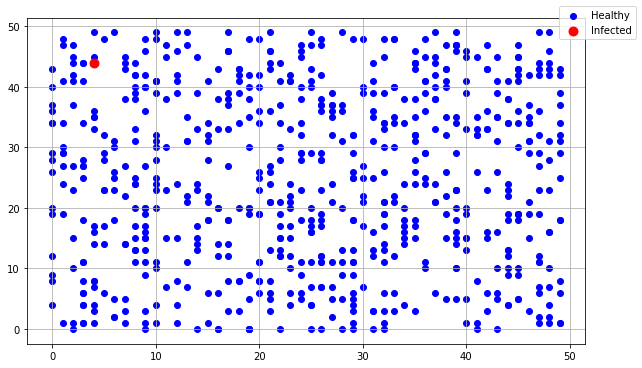

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [3]:
Initial =1
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=0,store="off",plot=True)
testings.runtime()

### Part 2 Random Walk by Timestep

Run for one infected and a timestep of 400

At day: 0
Sample mean sick [17. 39.]
Sample std sick [0. 0.]
Sample mean Healthy [24.53958944 23.96041056]
Sample std Healthy [14.56683611 14.69673548]
Number of infected =  1
Number of susceptible =  682


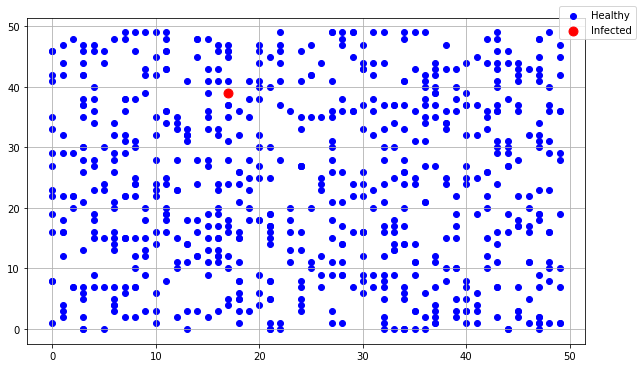

At day: 100
Sample mean sick [17.76119403 41.05970149]
Sample std sick [10.3413235   5.82296175]
Sample mean Healthy [26.43169399 20.04918033]
Sample std Healthy [14.77621091 12.39599149]
Number of infected =  134
Number of susceptible =  549


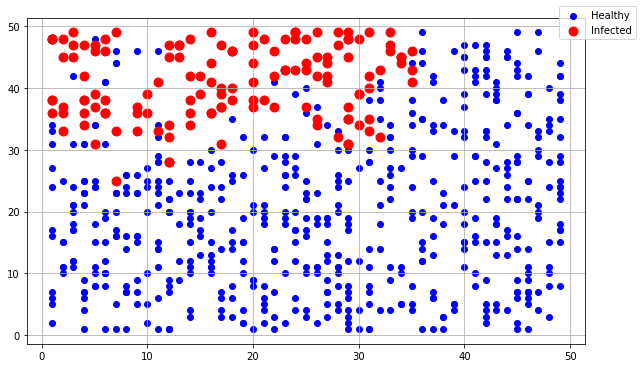

At day: 200
Sample mean sick [23.49377593 30.42946058]
Sample std sick [13.88516039 11.13442027]
Sample mean Healthy [29.10447761  8.94029851]
Sample std Healthy [14.30631596  6.78720027]
Number of infected =  482
Number of susceptible =  201


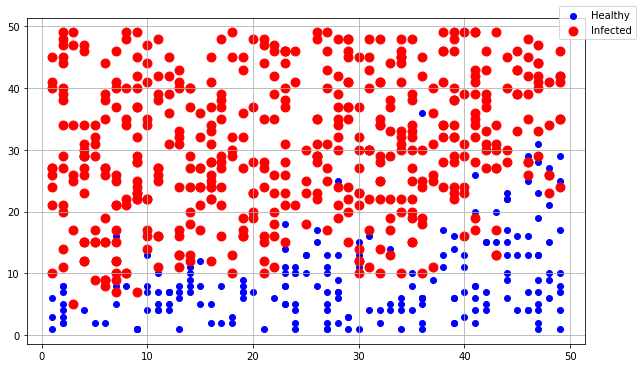

At day: 300
No mean or std calculated as S is 0


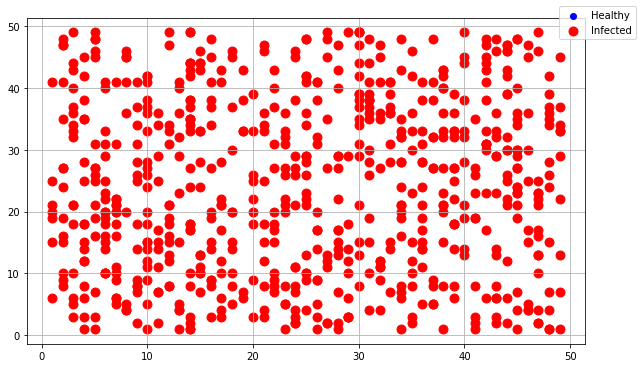

At day: 400
No mean or std calculated as S is 0


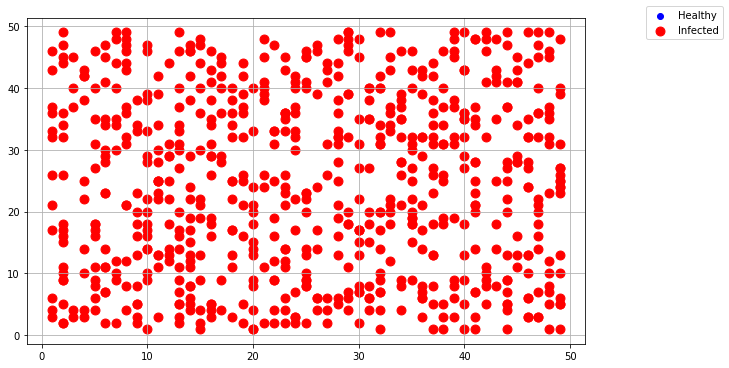

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [4]:
Initial =1
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=400,store="off",plot=True,plot_step=100)
testings.runtime()

We can see that even for one infected, as the walkers begin to move around it does not take long for the virus to begin spreading, after 100 days about 1/3, 1/4 is infected which makes it spread even quicker, causing the walkers to get infected quicker. The variance increases to its max when we get closer to half of the walkers getting infected which is logical. We are going to be studying the simulation mean later to confirm our results.

### Calculating the average across simulations 

The following function calculates the mean and standard deviation of our random walk model dependant on which parameters we choose to run for. We also included a way of checking approximately one standard deviation of each parameter so we can estimate the error of each of these parameters.

In [5]:
'''The following function was defined outside of the class to avoid the class becoming too large and difficult to navigate around.
   The function begins with allocating space, then running simulations from the class, and storing these into empty arrays. After that,
   we have to reshape the size of the array so that we can store the average across the timesteps into new empty arrays. The function was
   designed to be flexible to run the parameters we included as we want and to be able to use it across the entire project '''
   
def SimMean(Initial,sim,time_step,R_on=False,sd_on=True,V_on=False,D_on=False,beta_on=False):
    S=np.array([]) 
    I=np.array([])
    R=np.array([])
    V=np.array([])
    D=np.array([])

    S_arr=np.array([])
    I_arr=np.array([])
    R_arr=np.array([])
    V_arr=np.array([])
    D_arr=np.array([])

    S_sd=np.array([])
    I_sd=np.array([])
    R_sd=np.array([])
    V_sd=np.array([])
    D_sd=np.array([])

    value=np.array([])
    
    beta=np.array([])
    beta2=np.array([])
    beta_analytic = np.array([])
    vacc_numb = np.array([])


    for j in range(sim):
        testing=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=time_step,store='on',plot=False,
        vacc_on=V_on,recov_on=R_on,death_on=D_on,ave_on=True) #Run the simulations

        value=testing.runtime() # Store the simulated values into the array value
        S=np.append(S,value[0]) #0 - Susceptible
        I=np.append(I,value[1]) #1 - infected
        if R_on == True:
            R=np.append(R,value[2]) #2 - Recovery
        if V_on == True:
            V=np.append(V,value[3]) #3 - Vaccines
            vacc_numb=np.append(vacc_numb,value[-1])
            
        if D_on == True:
            D=np.append(D,value[4]) #4 - Deaths 

    S=S.reshape(sim,time_step) #Reshape the arrays to match the dimensions needed to plot
    I=I.reshape(sim,time_step)
    
    if R_on == True:
        R=R.reshape(sim,time_step)
    if V_on == True:
        V=V.reshape(sim,time_step)
        vacc_numb=vacc_numb.reshape(sim,1)
        vacc_numb=np.mean(vacc_numb)
        #print(vacc_numb)
    if D_on == True:
        D=D.reshape(sim,time_step)

    for i in range(time_step):
        S_arr=np.append(S_arr,np.mean(S[:,i])) # Take the mean across the simulations
        I_arr=np.append(I_arr,np.mean(I[:,i]))
        
        if R_on == True:
           R_arr=np.append(R_arr,np.mean(R[:,i]))
        if V_on == True:
            V_arr=np.append(V_arr,np.mean(V[:,i]))
        if D_on == True:
            D_arr=np.append(D_arr,np.mean(D[:,i]))
        if beta_on  ==  True:
            S_arr2=np.append(S_arr,np.median(S[:,i]))
            I_arr2=np.append(I_arr,np.median(I[:,i]))
            S_n=S_arr[1:]
            I_n=I_arr[1:]
            S_old=S_arr[:-1]
            S_n2=S_arr2[1:]
            I_n2=I_arr2[1:]
            S_old2=S_arr2[:-1]
            S_00=673
            beta_analytic = (1/152)*np.log((S_00*I_n)/((Initial*(683-I_n))))
            if np.all(S_n-S_old)==0.0:
                beta = non_zer
            else:
                beta=-1*(S_n-S_old)*683/(I_n*S_n)
                non_zer = np.copy(beta)
            
            if np.all(S_n2-S_old2)==0.0:
                beta2 = non_zer2
            else:
                beta2=-1*(S_n2-S_old2)*683/(I_n2*S_n2)
                non_zer2 = np.copy(beta2)

        if sd_on==True:
            S_sd=np.append(S_sd,np.mean(np.std(S[:,i]))) #Calculate the standard deviation
            I_sd=np.append(I_sd,np.mean(np.std(I[:,i])))
            if R_on == True:
                R_sd=np.append(R_sd,np.mean(np.std(R[:,i])))
            if V_on == True:
                V_sd=np.append(V_sd,np.mean(np.std(V[:,i])))
            if D_on == True:
                D_sd=np.append(D_sd,np.mean(np.std(D[:,i])))
   

    return S_arr,I_arr,R_arr,V_arr,D_arr,S_sd,I_sd,R_sd,V_sd,D_sd,beta, beta_analytic, beta2,vacc_numb

In [6]:
'' 'Run the data'  ''
Sim10=SimMean(1,10,400,R_on=False,sd_on=True)
Sim100=SimMean(1,100,400,R_on=False,sd_on=True)


In [7]:

'''The single plot function is a flexible plot function made to plot the parameters of interest which will be useful later, while 
   the dualplot function is made for the first exercise to showcase the difference in simulations for susceptible and infected walkers. '''

def SinglePlotFunction(S_on=True,I_on=True,R_on=True,V_on=False,D_on=False,sd_on=False,marker=False,beta_on=False,time_step=700):
    figure(figsize=(10,6))
    x=np.arange(0,time_step,1) # make a vector of the same size as the data
    if marker == False: #Turns off dotted lines
        if S_on == True:
            plt.plot(x,Sim100[0],label='Susceptible - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[0]-Sim100[5],Sim100[0]+Sim100[5],color='grey',alpha=0.25) #Approximately +- 1 standard deviation
        if I_on == True:
            plt.plot(x,Sim100[1],label='Infected - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[1]-Sim100[6],Sim100[1]+Sim100[6],color='grey',alpha=0.25)
        if R_on == True:
            plt.plot(x,Sim100[2],label='Recovered - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[2]-Sim100[7],Sim100[2]+Sim100[7],color='grey',alpha=0.25)
        if V_on == True:
            plt.plot(x,Sim100[3],label='Vaccinations - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[3]-Sim100[8],Sim100[3]+Sim100[8],color='grey',alpha=0.25)
        if D_on == True:
            plt.plot(x,Sim100[4],label='Deaths - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[4]-Sim100[9],Sim100[4]+Sim100[9],color='grey',alpha=0.25)
    if marker == True: #Turns on dotted lines   
        if S_on == True:
            plt.plot(x,Sim100[0],linestyle='--', linewidth=2.5,dashes=([6, 2]),label='Susceptible - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[0]-Sim100[5],Sim100[0]+Sim100[5],color='grey',alpha=0.25) #Approximately +- 1 standard deviation
        if I_on == True:
            plt.plot(x,Sim100[1],linestyle='--',linewidth=2.5, dashes=([6, 2]),label='Infected - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[1]-Sim100[6],Sim100[1]+Sim100[6],color='grey',alpha=0.25)
        if R_on == True:
            plt.plot(x,Sim100[2],linestyle='--',linewidth=2.5,dashes=([6, 2]),label='Recovered - RW')
            if sd_on==True:
                plt.fill_between(x,Sim100[2]-Sim100[7],Sim100[2]+Sim100[7],color='grey',alpha=0.25)
    if beta_on == True:
        val1=np.array([])
        testingss=RandomWalkEpidemicSimulator(no_init_infected=10, t0=0,tfinal=time_step,store="on")
        val=testingss.SIR_solver()
        x=np.arange(0, 700,1)
        plt.plot(x, val[0], 'b', alpha=0.5, lw=2, label='Susceptible - ODE')
        plt.plot(x, val[1], 'r', alpha=0.5, lw=2, label='Infected - ODE')
        plt.plot(x, val[2], 'g', alpha=0.5, lw=2, label='Recovered - ODE')
    plt.xlabel('Time-Step',fontsize=14)
    plt.ylabel('Population',fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()
    if V_on==True:
        print("Average number of vaccinations over 100 simulations is: ",Sim100[-1])
    if D_on==True:
        print("Average number of deaths over 100 simulations is: ", np.mean(Sim100[4]-1))

In [8]:
def DualPlotFunction(sd_on=True,time_step=400):
    x=np.arange(0,time_step,1)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 5))
    ax1.plot(x,Sim10[0],label='Susceptible - RW')
    ax1.plot(x,Sim10[1],label='Infected - RW')
    ax1.title.set_text('Average across 10 simulations')
    ax1.set_xlabel('Time-Steps')
    ax1.set_ylabel('Population')
    ax1.grid()
    ax1.legend()
    ax2.title.set_text('Average across 100 simulations')
    ax2.plot(x,Sim100[0],label='Susceptible - RW')
    ax2.plot(x,Sim100[1],label='Infected RW')
    ax2.set_xlabel('Time-Steps')
    ax2.set_ylabel('Population')
    ax2.grid()
    ax2.legend()
   
   
    if sd_on == True:
        ax1.fill_between(x,Sim10[0]-Sim10[5],Sim10[0]+Sim10[5],color='grey',alpha=0.25) #Approximately +- 1 standard deviation
        ax1.fill_between(x,Sim10[1]-Sim10[6],Sim10[1]+Sim10[6],color='grey',alpha=0.25)
        ax2.fill_between(x,Sim100[0]-Sim100[5],Sim100[0]+Sim100[5],color='grey',alpha=0.25)
        ax2.fill_between(x,Sim100[1]-Sim100[6],Sim100[1]+Sim100[6],color='grey',alpha=0.25)


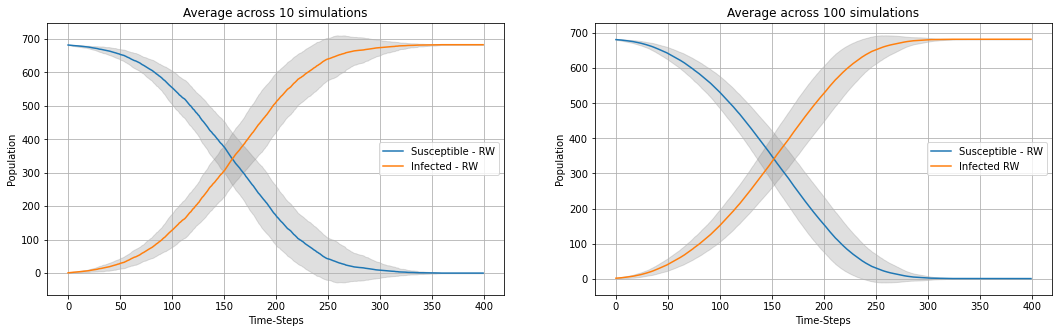

In [9]:
DualPlotFunction(sd_on=True,time_step=400)

From running the simulations and plots multiple times, they vary even with 100 simulations. Sometimes the variance is greater or smaller for the 100 simulations. This could be due to the movement of the infected person being placed at the edge of the grid for example which could restrict this walker back to his original position multiple times. 

### A detailed Plot for I(0)=1

The following plot has been designed to be able to hover over and see the development over time, this makes it easier to look at specific values.

In [10]:
data = {'Days':np.arange(0,400,1),'Susceptible':Sim100[0],'Infected':Sim100[1]}
df = pd.DataFrame(data)
fig = px.line(df, x='Days', y=['Susceptible','Infected'], labels={'value':'Population'},markers=True,
    title='Average across 100 simulations' )
fig.show()

### Part 3

At day: 0
Sample mean sick [25.7 26.6]
Sample std sick [13.83510029 12.67438361]
Sample mean Healthy [25.43090639 24.56315007]
Sample std Healthy [14.23382725 14.21432037]
Number of infected =  10
Number of susceptible =  673


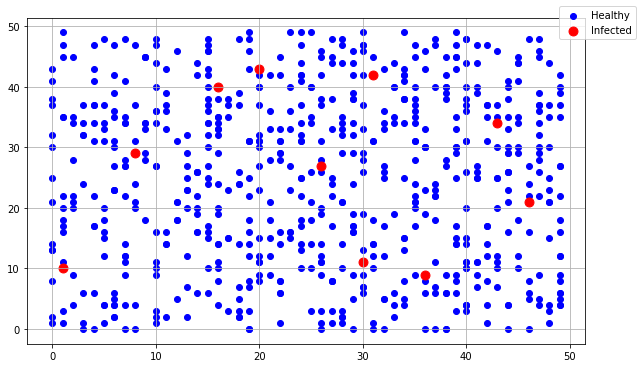

At day: 100
Sample mean sick [25.66088328 24.80757098]
Sample std sick [14.56856355 14.42278055]
Sample mean Healthy [26.79591837 21.95918367]
Sample std Healthy [ 9.06209777 11.75421624]
Number of infected =  634
Number of susceptible =  49


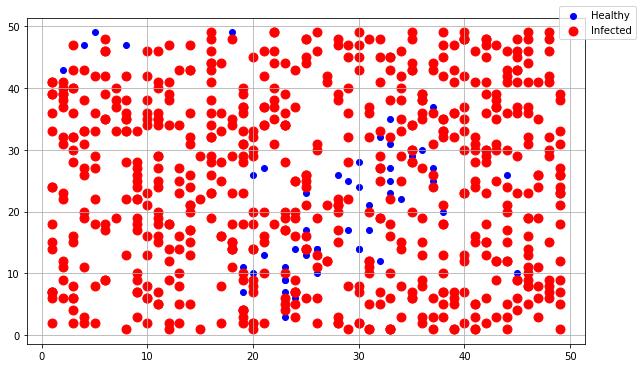

At day: 200
No mean or std calculated as S is 0


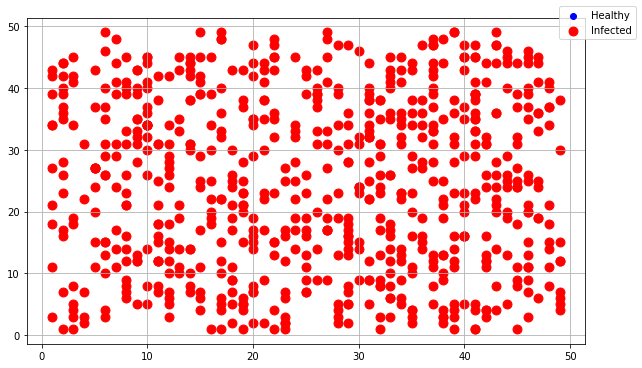

At day: 300
No mean or std calculated as S is 0


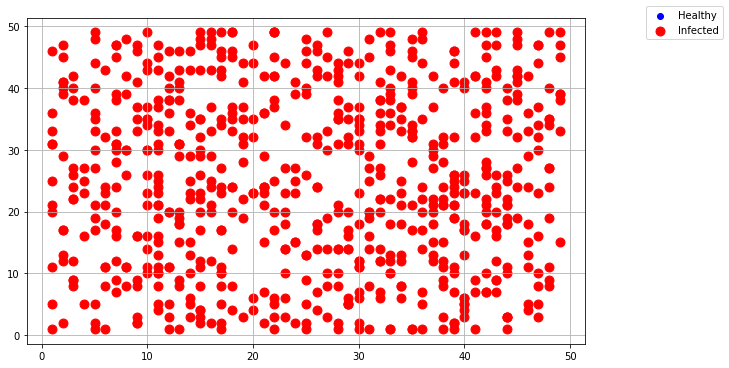

At day: 400
No mean or std calculated as S is 0


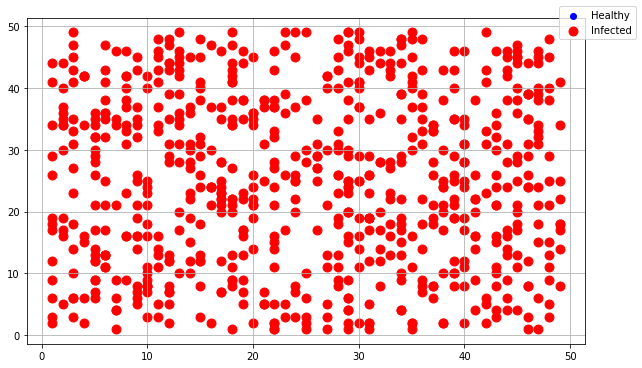

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [11]:
Initial =10 #Starting with 10 infected, I(0)=10
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=400,plot=True,store='off',plot_step=100)
testings.runtime()

In these plots we can see that our samples are getting infected at a faster pace, as the constraints such as being placed at the edge of the grid are very unlikely to happen. We also expect the variance to decrease as a result of this in comparison to our old model. 

### Plots for 10 initial infected

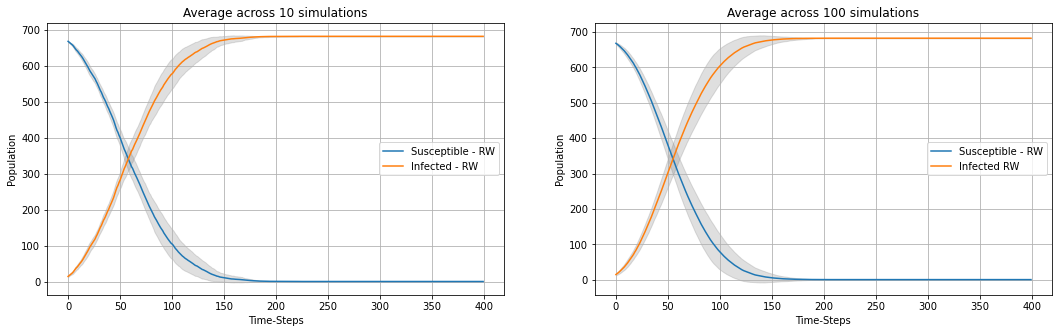

In [12]:
Sim10=SimMean(Initial=10,sim=10,time_step=400,R_on=False) # I(0)=10, 
Sim100=SimMean(Initial=10,sim=100,time_step=400,R_on=False)
DualPlotFunction()

### Comparing the plots for I(0) = 10 to the plots of I(0)=1

By observing we can see that the samples are getting infected faster with ten initial infected walkers than with one which is expected, As people are getting infected at a faster rate this causes all walkers to get infected on average around 150 timesteps, this reduces the variance which we expected to happen.

### A detailed Plot for I(0)=10

In [13]:
data = {'Days':np.arange(0,400,1),'Infected':Sim100[1],'Susceptible':Sim100[0]}
df = pd.DataFrame(data)
fig = px.line(df, x='Days', y=['Infected','Susceptible'], labels={'value':'Population'},markers=True,
    title='Average across 100 simulations' )
fig.show()

When we increase the number of initial infected to 10, the std of infected is close to the one of the std of healthy. This is obvious because the initial infected is placed in random different locations. However, I would assume that the infection would spread faster when increasing the initial infection. What´s interesting is that for I(0)=1, at day 35, the number of infected is ten times the initial. However, for I(0)=10, at day 35, the infection has only increased by a factor of 1,5. 

### Investigation on time

In [14]:
Initial =10
loop=RandomWalkEpidemicSimulator(Initial,loop=True, t0=0,tfinal=400,store="off",plot=False,vacc_on=True,recov_on=True,death_on=True,move_old=True,plot_step=100,ave_on=True)
no_loop=RandomWalkEpidemicSimulator(Initial,loop=False, t0=0,tfinal=400,store="off",plot=False,vacc_on=True,recov_on=True,death_on="test",move_old=True,plot_step=100,ave_on=True)


With a for loop for infection

In [15]:
%%timeit
loop.runtime()

8.87 s ± 409 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Without a for loop for infection

In [16]:
%%timeit
no_loop.runtime()

436 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The example above above shows how much time is saved when the infection spreading function has a loop and when it has no loops. From the above illustration it can be seen that requires over 10 times more time for the scenario with a loop than for the scenario without a loop.

## Exercise 2: Compare random walk and ODE- based models

### Part 1

In [17]:
Sim100=SimMean(10,100,400,beta_on=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_32548\3674225874.py:92: RuntimeWarning:

divide by zero encountered in true_divide



In [18]:

def betaPlot(Beta_mean=Sim100[10],Bet2=Sim100[11],Beta_median=Sim100[12],Beta_one=False,Beta_two=False,Beta_analytical=False):
    figure(figsize=(10,6))
    if Beta_one == True:
        non_zer=0.1
        Beta_mean[Beta_mean == 0] = non_zer
        Beta_median[Beta_median == 0] = non_zer
        plt.plot(Beta_mean, c='red', label='Mean beta')
        plt.plot(Beta_median[:-1], c='blue', label='Median beta')
        plt.title('Variation of beta for each simulation')
        plt.xlabel('Simulations')
        plt.ylabel('Beta')
        plt.grid()
        plt.legend()
        plt.show()
        print("The mean of beta across 100 simulations is: ",np.mean(Beta_mean))
        print("The median across 100 simulations is: ",np.median(Beta_median))
    elif Beta_two == True:
        plt.plot(Bet2)
        plt.grid()
        plt.show()
        print("The mean of beta2 across 100 simulations is: ",np.mean(Bet2))
        print("The median of beta2 across 100 simulations is: ",np.median(Bet2))
    elif Beta_analytical == True:
        testings=RandomWalkEpidemicSimulator(no_init_infected=1, t0=0,tfinal=400,store="on")
        testings2=RandomWalkEpidemicSimulator(no_init_infected=10, t0=0,tfinal=400,store="on")
        value1=testings.ode_plot()
        value2=testings2.ode_plot()
        t_list = np.linspace(0, 400, 80)
        plt.plot(t_list, value1[0](), '-',color = 'Red',label = 'Susceptibles for I0=1')
        plt.plot(t_list, value1[1](),'-', color = 'Red',label = 'Infected for I0=1')
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.plot(t_list, value2[0](), '',color = 'Blue',label = 'Susceptibles for I0=10')
        plt.plot(t_list, value2[1](),'-', color = 'Blue',label = 'Infected for I0=10')
        plt.legend(bbox_to_anchor=(1.4, 1.2))
        plt.ylabel('Population')
        plt.xlabel('Time-steps')
        plt.title("Analytical solution I(0)=1 and I(0)=10")
        plt.grid()
        plt.show()

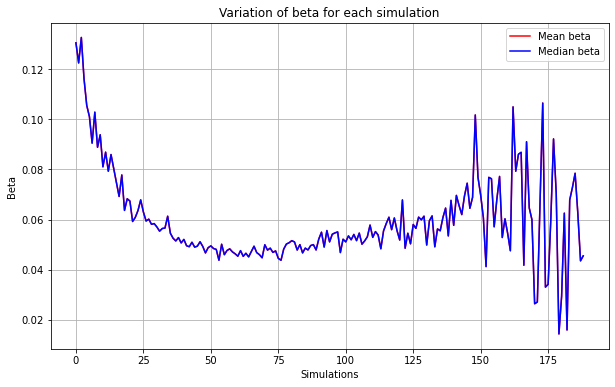

The mean of beta across 100 simulations is:  0.05958293268776466
The median across 100 simulations is:  0.05480958194195841


In [19]:
betaPlot(Beta_one=True)

According to the plot above, there is little difference in the mean value of beta compared to the median value of beta. Note that we had to remove the last value from the median beta as this was an extreme value. Taking the mean or the median again, we get the value for the beta which we will use in the next exercise to obtain a solution to the ODE-based, deterministic SI-model.

#### Alternative solution 
We can also find a non-constant function for $\beta = \beta(t)$ by basically manipulation equation 1 and 2. Firstly, we have that the infection rate is given by:
$$I(t)=ln(\frac{N}{1+\frac{S_0}{I_0}e^{(-\beta t)}}) \rightarrow \frac{I(t)}{N} = \frac{1}{1+\frac{S_0}{I_0}e^{(-\beta t)}} \rightarrow \frac{I(t)}{N} = 1 + \frac{S_0}{I_0}e^{(-\beta t)}$$ 
$$\frac{I(t)}{N}\frac{S_0}{I_0} = 1\frac{S_0}{I_0} + e^{(-\beta t)} \rightarrow \frac{I_0}{S_0}(\frac{I(t)}{N} - 1) = e^{(-\beta t)}$$ 
Find inverse:
$$\frac{S_0}{I_0}(\frac{1}{\frac{N}{I(t)}-1} ) = e^{\beta t} \rightarrow \frac{S_0}{I_0}(\frac{I(t)}{N-I(t)} ) = e^{\beta t}$$
Take ln on both sides
$$ln(\frac{S_0 I(t)}{I_0(N-I(t))}) = {\beta t}$$
Now:
$$ {\beta} = \frac{1}{t}ln(\frac{S_0I(t)}{I_0(N-I(t))})$$

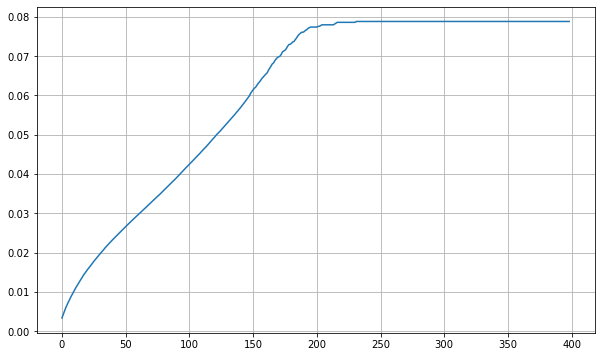

The mean of beta2 across 100 simulations is:  0.06090808404732969
The median of beta2 across 100 simulations is:  0.07734723104217733


In [20]:
betaPlot(Beta_two=True)

In the numerical beta value, we have several drops. These can be described by the fact that for each step subtract the previous number of susceptibles, which increases randomly. Note that $\beta = 0$ is replaced by the value of $\beta = 0.1$, which seemed reasonable as most values fall above 0.1. The $\beta$ starts at 0.2 for the first simulation and drops rapidly down to a value of about 0.05. Also note that from simulation 100, $\beta$ starts to oscillate more drastically. At the middle point where the oscillation in $\beta$ is at its smallest value is also the point where a number of infected and susceptible crosses. 

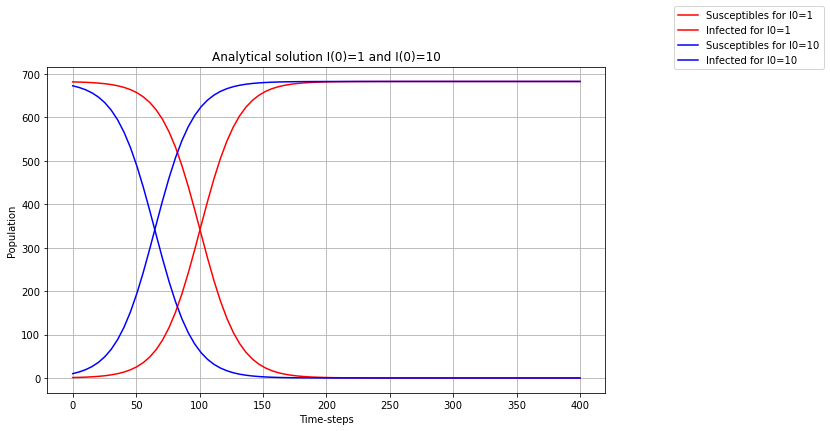

In [21]:
betaPlot(Beta_analytical=True)

According to our calculations, $\beta=0.65$ seemes to be a good fit. 

### Part 2

Implementing a recovery to the random walk model with the probability of recovery = 0

At day: 0
Sample mean sick [19.  20.1]
Sample std sick [10.44030651 15.21479543]
Sample mean Healthy [24.39970282 24.71768202]
Sample std Healthy [14.25648519 14.71383089]
Number of infected =  10
Number of susceptible =  673


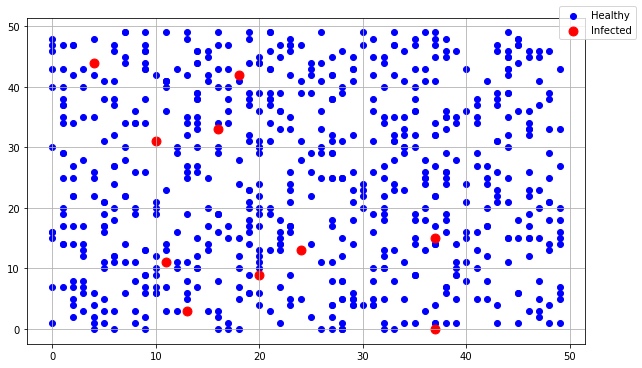

At day: 175
Sample mean sick [23.86716418 23.77910448]
Sample std sick [14.40808115 14.367527  ]
Sample mean Healthy [44.92307692 45.61538462]
Sample std Healthy [3.47433532 2.78839522]
Number of infected =  670
Number of susceptible =  13


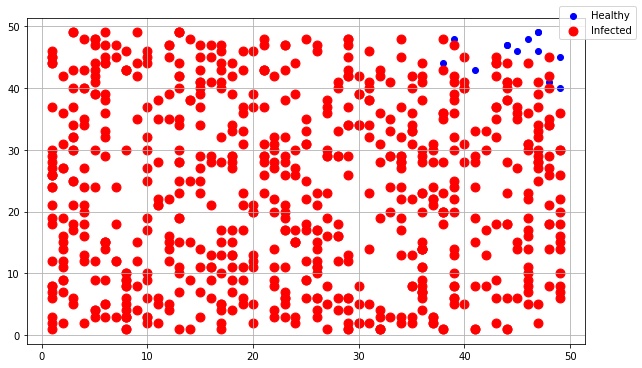

At day: 350
No mean or std calculated as S is 0


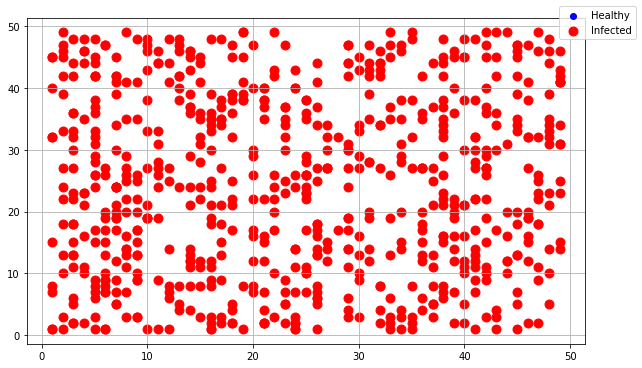

At day: 525
No mean or std calculated as S is 0


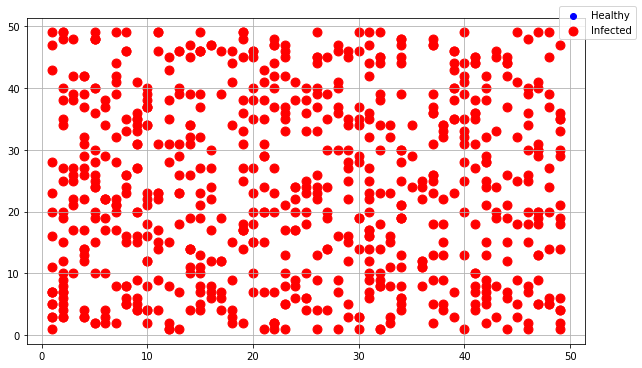

At day: 700
No mean or std calculated as S is 0


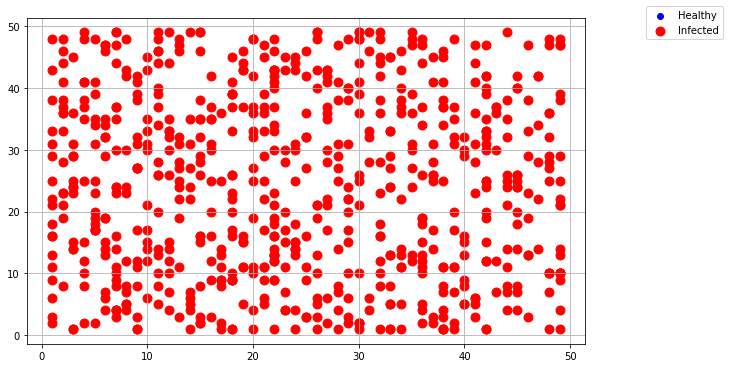

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [22]:
Initial =10 #Starting with 10 infected, I(0)=10
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=700,plot=True,store='off',recov_on=False,plot_step=175)#Turning off recovery so that the probability is 0
testings.runtime()

### Part 3

Allowing people to recover from the disease with I(0)=10, $P_{recover}=0.01$

At day: 0
Sample mean sick [22.8 28.3]
Sample std sick [11.50478161 15.03362897]
Sample mean Healthy [23.94205052 25.60029718]
Sample std Healthy [14.44015883 14.35215553]
Number of infected =  10
Number of susceptible =  673


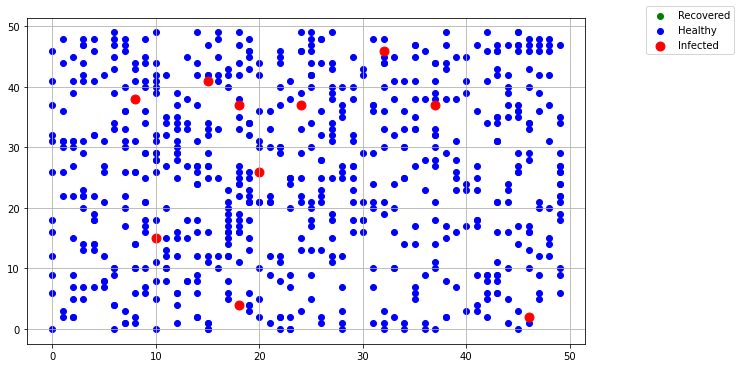

At day: 175
Sample mean sick [23.9047619  22.11688312]
Sample std sick [14.77858295 13.90534547]
Sample mean Healthy [0. 0.]
Sample std Healthy [0. 0.]
Number of infected =  231
Number of susceptible =  1


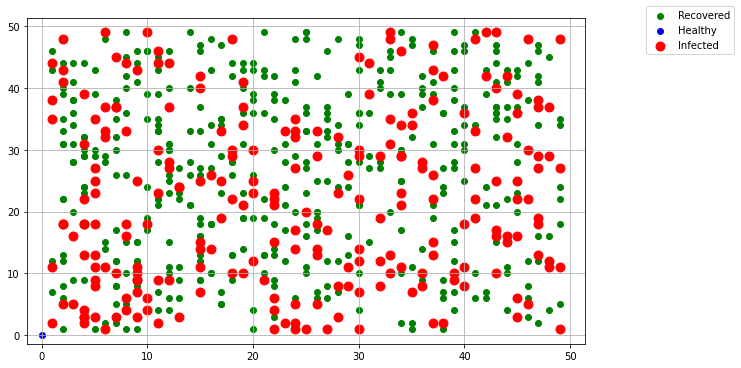

At day: 350
Sample mean sick [23.23255814 23.97674419]
Sample std sick [14.91189194 13.09267214]
Sample mean Healthy [0. 0.]
Sample std Healthy [0. 0.]
Number of infected =  43
Number of susceptible =  1


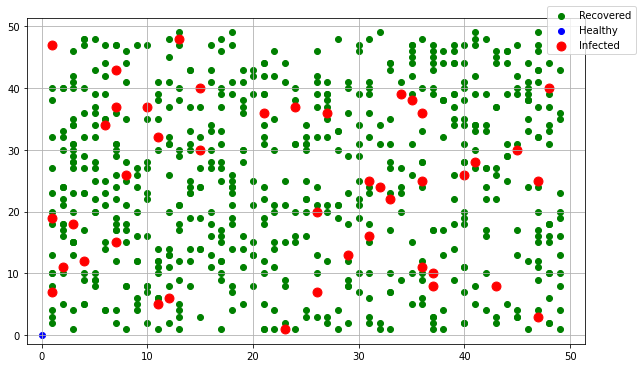

At day: 525
Sample mean sick [30.75 14.75]
Sample std sick [15.44951456 12.02861172]
Sample mean Healthy [0. 0.]
Sample std Healthy [0. 0.]
Number of infected =  4
Number of susceptible =  1


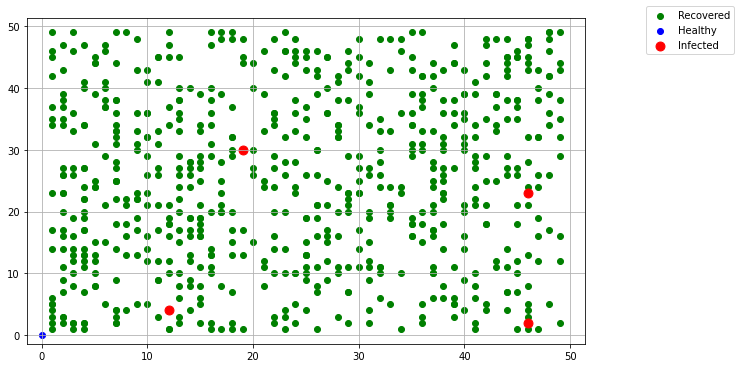

At day: 700
Sample mean sick [nan nan]
Sample std sick [nan nan]
Sample mean Healthy [0. 0.]
Sample std Healthy [0. 0.]
Number of infected =  0
Number of susceptible =  1


c:\Users\mariu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

c:\Users\mariu\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\mariu\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\mariu\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\mariu\anaconda3\lib\site-packages\numpy\core\_methods.py:251: RuntimeWarning:

invalid value encountered in true_divide



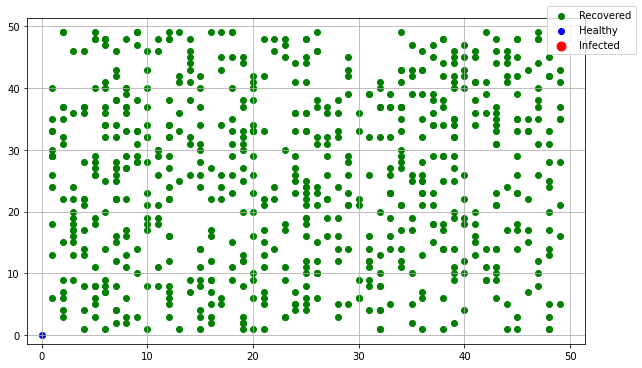

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [23]:
Initial =10 #Starting with 10 infected, I(0)=10
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=700,plot=True,store='off',recov_on=True,plot_step=175)
testings.runtime()

As we can see, the recovery works well with the random walk model. Even having a recovery percentage of 0.01 we can observe that most walkers will change state to recovered. 

In [24]:
Sim100=SimMean(R_on=True,Initial=10,sim=100,time_step=700,beta_on=True)

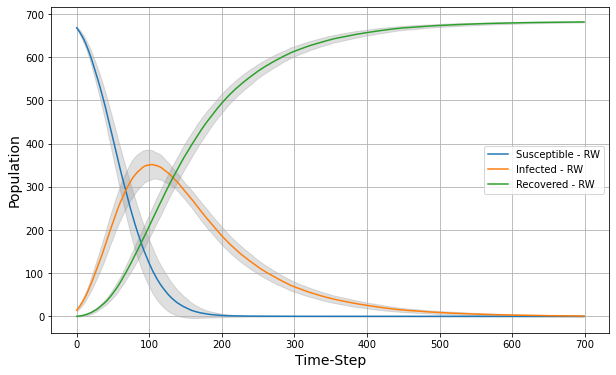

In [25]:
SinglePlotFunction(R_on=True,sd_on=True,time_step=700,marker=False,beta_on=False)

### Part 4

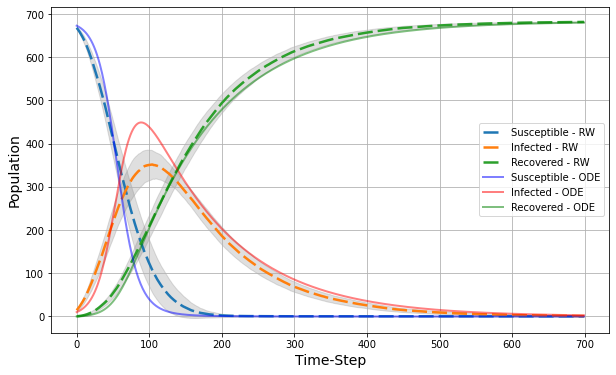

In [26]:
SinglePlotFunction(R_on=True,sd_on=True,time_step=700,marker=True,beta_on=True)

As we can see in the plot, the susceptibles from the random walk are close to the analytical solution. Susceptibles drop slightly faster and the number of people getting infected is also higher in the analytical solution. Recovery seems very similar to both models, the expectancy of infections could also be based on the faster drop in susceptibles.

### Exercise 3: Implement your own scenario

We have chosen to implement vaccination, death with age, and slower movement with age. Norway has an old population percentage of about 18% (ECONOMICS, 2022) and this has made us use that same percentage for the population size. The death parameter was constructed for old people, over 95% of individuals that died from the covid 19 outbreak were 50 years and above   (Elflein, 2022). This exercise will show the implementations and the findings gotten by introducing these new parameters.

Model 1: People get vaccinated, and people die with in relation to age and older people have slower movements about 50% on average.

At day: 0
Sample mean sick [22.2 23.1]
Sample std sick [14.09113196 12.40524083]
Sample mean Healthy [25.27191679 23.8692422 ]
Sample std Healthy [14.12348635 14.51772976]
Number of infected =  10
Number of susceptible =  673
Number of dead =  0


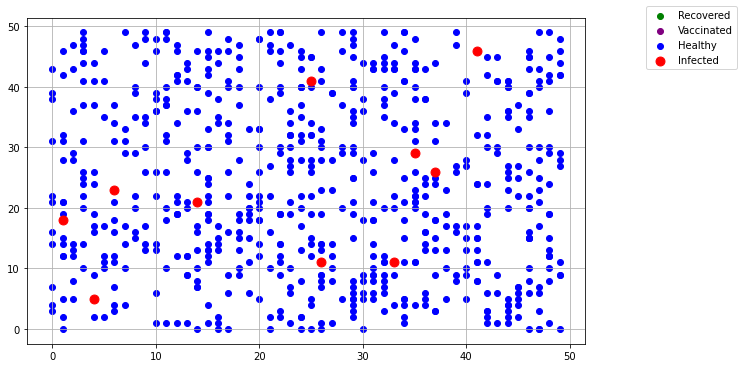

At day: 100
Sample mean sick [24.22938144 23.9871134 ]
Sample std sick [13.37240051 14.05942245]
Sample mean Healthy [35.54166667 21.97916667]
Sample std Healthy [15.87051555 18.64636871]
Number of infected =  388
Number of susceptible =  48
Number of dead =  2


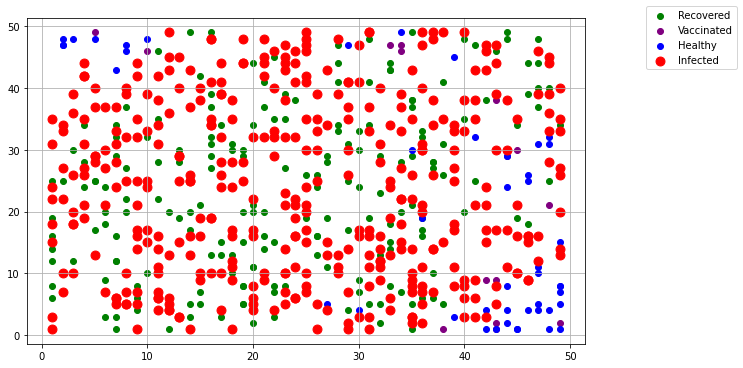

Number of vaccinated at 100 =16
At day: 200
No mean or std calculated as S is 0
Number of dead =  8


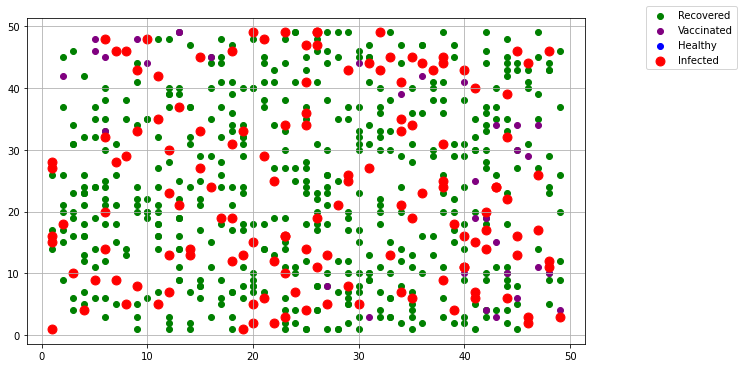

Number of vaccinated at 200 =34
At day: 300
No mean or std calculated as S is 0
Number of dead =  11


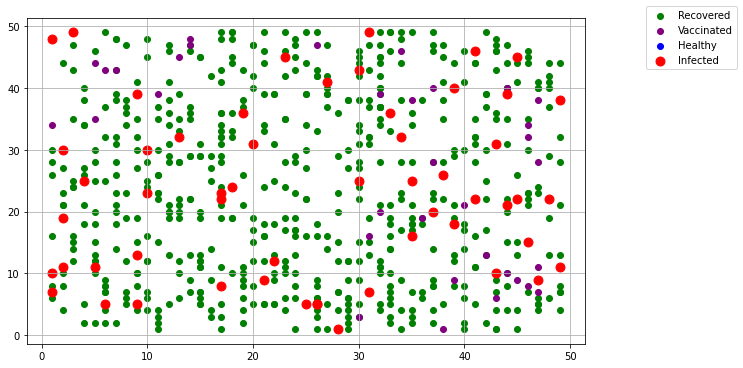

Number of vaccinated at 300 =34
At day: 400
No mean or std calculated as S is 0
Number of dead =  12


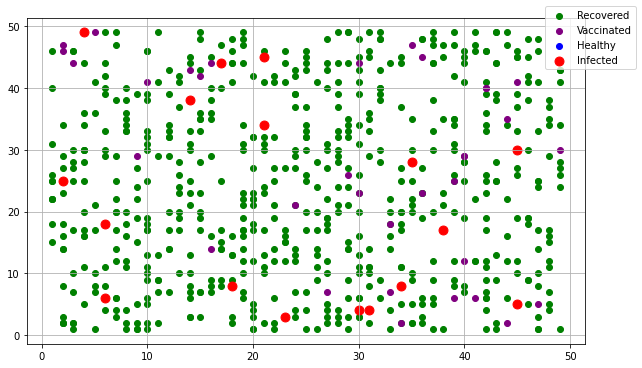

Number of vaccinated at 400 =34
At day: 500
No mean or std calculated as S is 0
Number of dead =  15


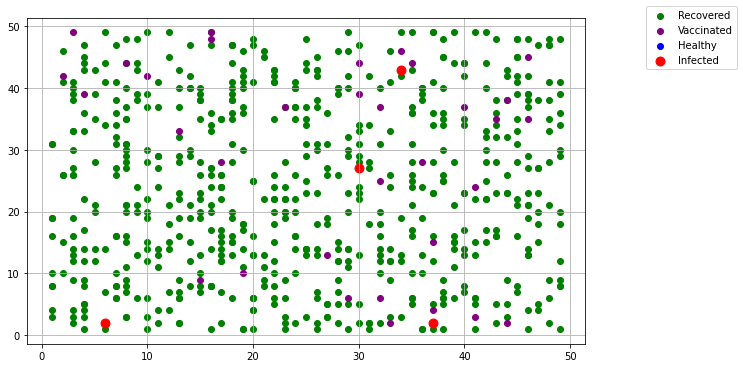

Number of vaccinated at 500 =34
At day: 600
No mean or std calculated as S is 0
Number of dead =  15


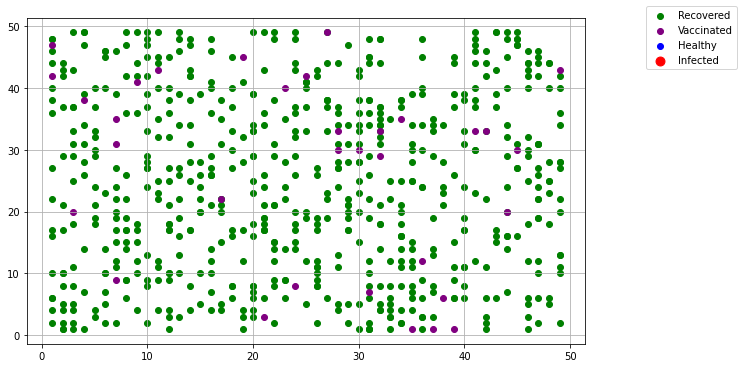

Number of vaccinated at 600 =34
At day: 700
No mean or std calculated as S is 0
Number of dead =  15


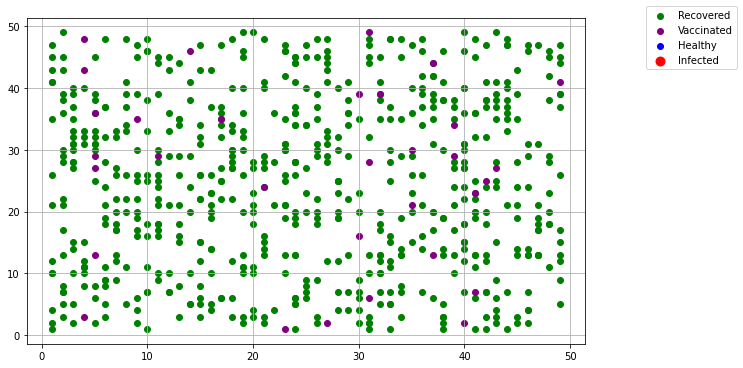

Number of vaccinated at 700 =34


(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 34)

In [27]:
Initial =10
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=700,store="off",plot=True,vacc_on=True,recov_on=True,death_on=True,move_old=True,plot_step=100,ave_on=False)
testings.runtime()

### Using the Plot Function

To study the effects of vaccinations, age-related deaths, etc. We can now use the plot function created in exercise 1. where you can look at the parameters you want to study. The plot will still be dependent on the parameters in the SimMean model, but we will be able to determine which parameters are dominant and which are not and the effects they may have. 

In [28]:
Sim100=SimMean(Initial=10,R_on=True,V_on=True,D_on=True,sd_on=True,time_step=700,sim=100)

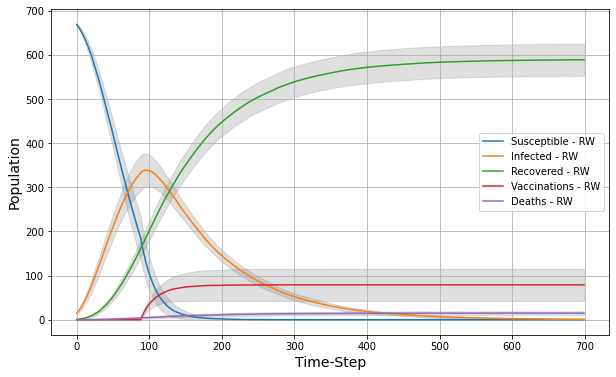

Average number of vaccinations over 100 simulations is:  79.09
Average number of deaths over 100 simulations is:  10.621714285714287


In [29]:
SinglePlotFunction(S_on=True,I_on=True,R_on=True,V_on=True,D_on=True,sd_on=True,marker=False,time_step=700, beta_on=False) #Pick the parameters you want to display

Model 2: The model below takes into account that individuals do not immediately start to spread infection after they are infected it takes about three days before they begin to spread the disease.

At day: 0
Sample mean sick [32.7 21.4]
Sample std sick [13.13049885 12.19180052]
Sample mean Healthy [24.02674591 24.86775632]
Sample std Healthy [14.17128915 14.22506579]
Number of infected =  10
Number of susceptible =  673
Number of dead =  0
Number of potential infected day1 =  0
Number of potential infected day2 =  0


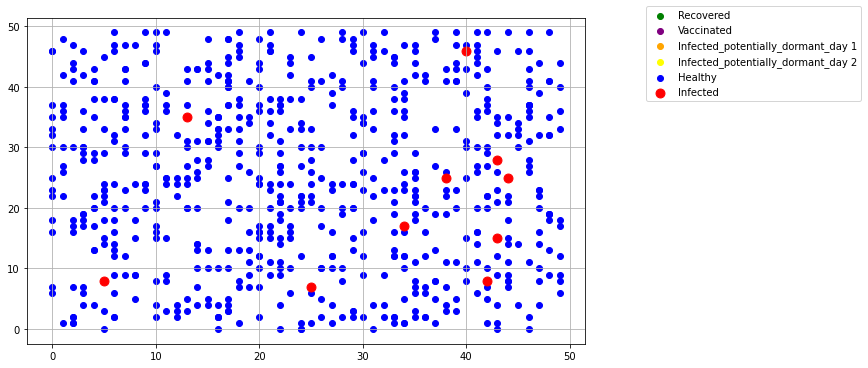

At day: 100
Sample mean sick [23.61007958 23.77453581]
Sample std sick [13.9064401 13.8672979]
Sample mean Healthy [16.34782609 33.        ]
Sample std Healthy [ 9.47892565 10.93458812]
Number of infected =  377
Number of susceptible =  69
Number of dead =  8
Number of potential infected day1 =  3
Number of potential infected day2 =  3


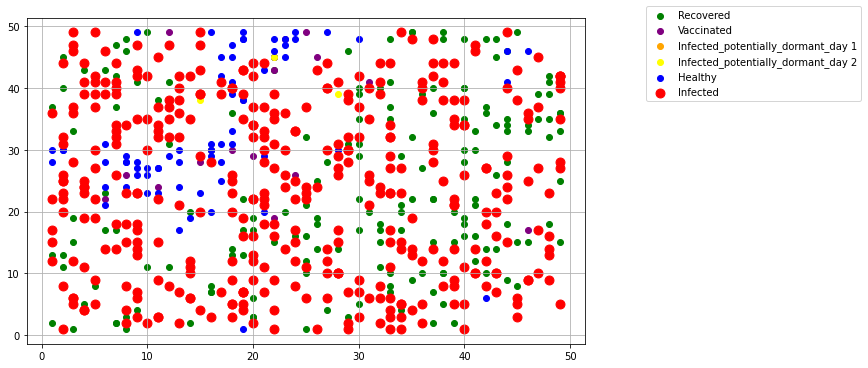

Number of vaccinated at 100 =20
At day: 200
No mean or std calculated as S is 0
Number of dead =  19
Number of potential infected day1 =  1
Number of potential infected day2 =  1


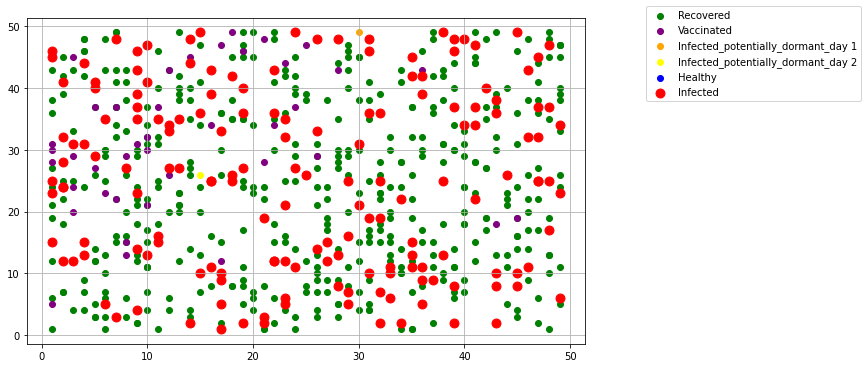

Number of vaccinated at 200 =46
At day: 300
No mean or std calculated as S is 0
Number of dead =  21
Number of potential infected day1 =  1
Number of potential infected day2 =  1


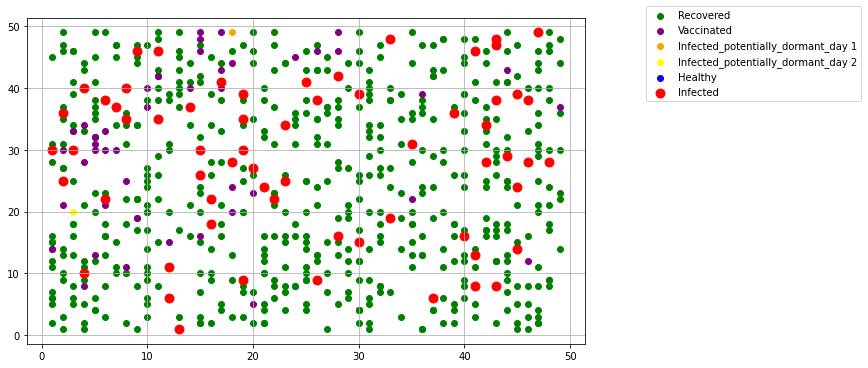

Number of vaccinated at 300 =46
At day: 400
No mean or std calculated as S is 0
Number of dead =  22
Number of potential infected day1 =  1
Number of potential infected day2 =  1


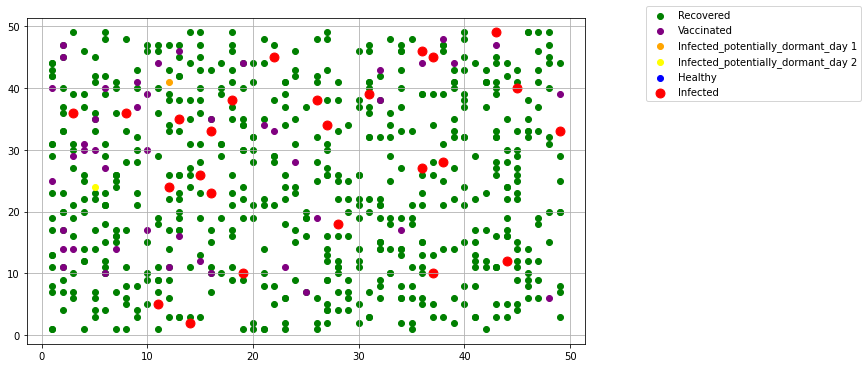

Number of vaccinated at 400 =46
At day: 500
No mean or std calculated as S is 0
Number of dead =  22
Number of potential infected day1 =  1
Number of potential infected day2 =  1


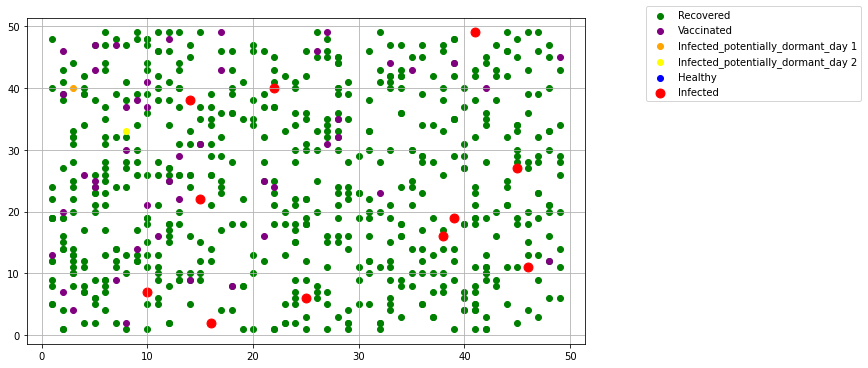

Number of vaccinated at 500 =46
At day: 600
No mean or std calculated as S is 0
Number of dead =  23
Number of potential infected day1 =  1
Number of potential infected day2 =  1


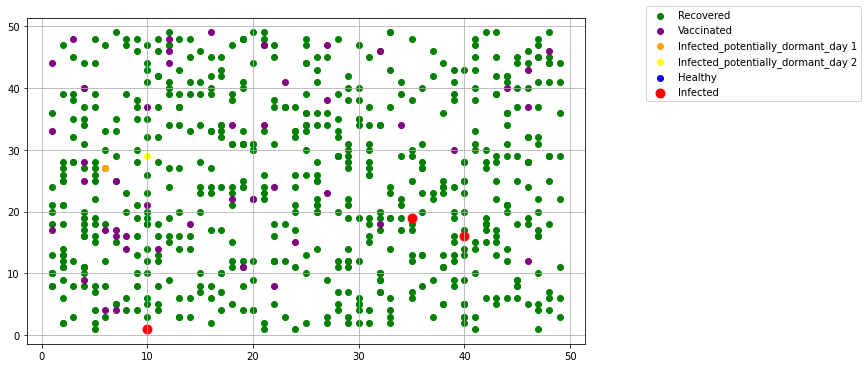

Number of vaccinated at 600 =46
At day: 700
No mean or std calculated as S is 0
Number of dead =  23
Number of potential infected day1 =  1
Number of potential infected day2 =  1


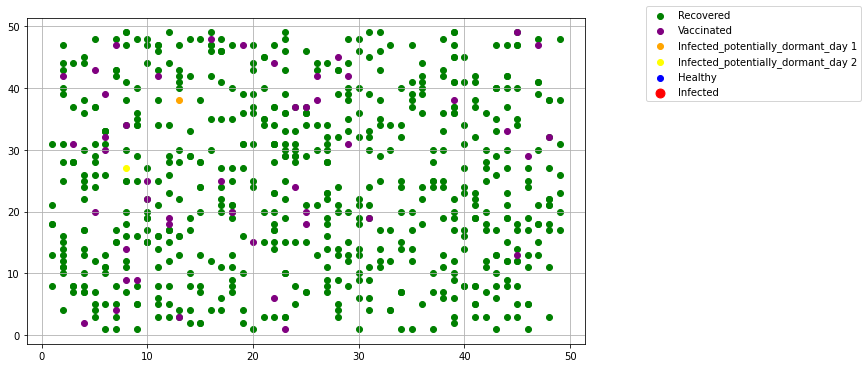

Number of vaccinated at 700 =46


(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 46)

In [30]:
Initial =10
testings=RandomWalkEpidemicSimulator(Initial, t0=0,tfinal=700,store="off",plot=True,vacc_on=True,recov_on=True,death_on=True,move_old=True,plot_step=100,ave_on=False,potential=True)
testings.runtime()

The design of our SimMean function is dependent on which parameters we want to run for. Originally we wanted the plot function to decide which parameters to plot, but running all of the parameters in the SimMean impacts the plot regardless of what we show for. 

From the simulations above, we can see that the average number of vaccinations within a time frame of 400 days, is approximately 74.8. With the vaccination starting after 90 time steps of the infection spreading. We have also observed that the number of infected people converges towards zero after day 100 and is quite low at day 600. The limitation of this final model is that it does not take into account, that people have restricted movement after they start to spread the coronavirus. This could be implemented if we had additional time to develop the code. The code does not make recovered people get vaccinated because we believe that people infected by Covid-19 do not need to go for vaccination after they have been infected. Which implies that an infection counts as a vaccination. The individuals who have been vaccinated or recovered stand a lower chance of getting infected again. 

The code could be expanded to account for people getting vaccinated after recovery to further lower their chances of getting infected, but that might be slightly complex and hard to control.

## Conclusion
One of the natures of the random walk is that one needs to run the simulator many times as it produces the uncertainty, $\sigma$. Clearly, with more simulations, $\sigma$ becomes smaller. For an even better estimate, one would wish to run the random walk an infinite amount of times.  As we introduce more scenarios to the model, like recovery time and vaccination, the model becomes more realistic and the number of infected decreases significantly. For an even more realistic model, one would also introduce scenarios of the use of masks, differences in age gaps, and quarantine. During the pandemic, it was also some ongoing research about how different blood types had an impact on the number of infected. According to a paper published by the national library of medicine, blood groups A, B, and Rh+ were more susceptible to infection by covid-19. Blood groups O, AB, and Rh− are at a lower risk.[2] 

The random walk simulator depends largely on the initial number of infected. A larger number of initial infected, results in a steeper growth of infected. Comparing the walker with the analytical solution, one can see that the number of infected grows faster in the analytical solution with $I(0)=1$ than for the walker. The analytical solution and random walker are in better agreement for $I(0)=10$. It seems that the analytical solution is less affected by changing the initial number of infected. The analytical solution, however depends on the parameter $\beta$, the disease transmission rate. For this purpose, we compared both, the numerical $\beta$, and the analytical $\beta_{analytical}$. Since $\beta_{analytical}$ depends on the change in I, the number of infected, it does not change when we introduce scenarios such as recovery, vaccination, and such. $\beta_{analytical}$ is therefore a bad choice as the result converges to I being the entire population infected. Introducing both death and vaccination implies a decrease in the number of infected. The death rate is very small. With vaccination and death, a better result would be obtained by introducing a larger population and looking at the effect over a larger amount of time. 

## Reflections
Marianne: Again, I think it was very interesting to work on a real world problem, especially covid which have had a big inpact on our lifes. Implementing the random walker was for me very challanging, which was obviously the largest amount of work with this project. As soon the walker of the SI-model were up running, the motivation to improve the model by introducing diferent scenarios increased. 

Marius: For me personally the challenge of this project was how open it was, and what you could make out of it yourself. I found it fun to challenge myself on using the least amount of for loops that we could. Trying to figure out ways of optimizing the code and implementing new ideas. And i agree with Marianne that getting the SI-model optimized and running well took the most amount of time, as the project beyond that point went smoothly. For me personally this has been the best course this semester as doing something that feels meaningful and has real world applications has been very enjoyable, the learning curve has been steep and I am very much appreciative.

Olufisayo: I think the project was intresting I got to understand how a marco chain markov process(random walk) can be used to simulate a real life process. This was quite interesting and the fact that were had a open ended exercise at the end really gives room for a lot of creativity. The project basically requires you to use all your past knowledge from all other previous projects to develop this project. I have learnt so much from the course and my python programming skills have really gone from 0 to some intermediate level. Overall the course feels like a 15 credit course judging the ammount of time spent on the projects but I can definitely say that the knowledge gained is worth it.

## References

[1] Kirkeby, C., Halasa, T., Gussmann, M., Toft, N., &amp; Græsbøll, K. (2017, August 25). Methods for estimating disease transmission rates: Evaluating the precision of Poisson regression and two novel methods. Nature News. Retrieved December 12, 2022, from https://www.nature.com/articles/s41598-017-09209-x 

[2] Kim, Y., Latz, C. A., DeCarlo, C. S., Lee, S., Png, C. Y. M., Kibrik, P., Sung, E., Alabi, O., &amp; Dua, A. (2021, September). Relationship between blood type and outcomes following covid-19 infection. Seminars in vascular surgery. Retrieved December 12, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8286549/ 

[3] Norway - population ages 65 and above (% of total)2022 data 2023 forecast 1960-2021 historical. Norway - Population Ages 65 And Above (% Of Total) - 2022 Data 2023 Forecast 1960-2021 Historical. (n.d.). Retrieved December 12, 2022, from https://tradingeconomics.com/norway/population-ages-65-and-above-percent-of-total-wb-data.html?fbclid=IwAR2IVTFk4Nr3JfUorgpZd_QQsO_9fERkF-YPtQSN_WnOG7-Mi9f8N_qClHE#:~:text=Population%20ages%2065%20and%20above%20(%25%20of%20total%20population)%20in,compiled%20from%20officially%20recognized%20sources 

[4] Elflein, J. (2022, December 9). Covid-19 deaths by age U.S. 2022. Statista. Retrieved December 12, 2022, from https://www.statista.com/statistics/1191568/reported-deaths-from-covid-by-age-us/ 

[5] Centers for Disease Control and Prevention. (n.d.). Covid Data Tracker Weekly Review. Centers for Disease Control and Prevention. Retrieved December 12, 2022, from https://www.cdc.gov/coronavirus/2019-ncov/covid-data/covidview/index.html 


